In [77]:
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

In [65]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [16]:
df = pd.read_csv('BOE-XUDLERD.csv')

In [17]:
df.head()

,Date,Value
0,2017-11-09,0.8603
1,2017-11-08,0.8631
2,2017-11-07,0.8639
3,2017-11-06,0.8631
4,2017-11-03,0.8608


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10837 entries, 0 to 10836
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    10837 non-null  object 
 1   Value   10837 non-null  float64
dtypes: float64(1), object(1)
memory usage: 169.5+ KB


In [22]:
df['Date']=pd.to_datetime(df['Date'])
new_df= df.set_index('Date')

In [25]:
new_df
ts=new_df['Value']
type(ts)   # created a series

pandas.core.series.Series

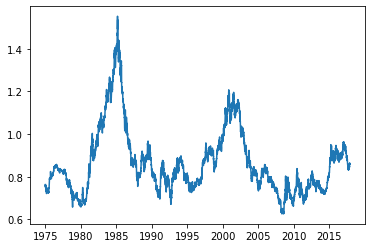

In [26]:
plt.plot(ts)

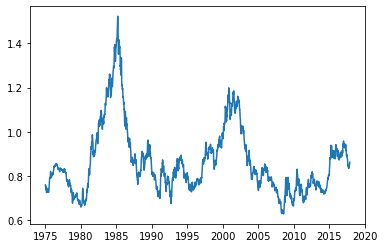

In [41]:
ts_week = ts.resample('W').mean()
plt.plot(ts_week) # weekly plot

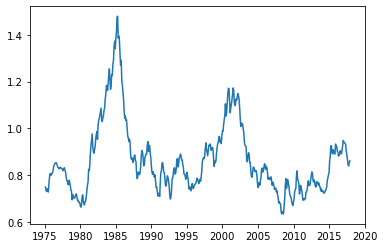

In [30]:
ts_mth = ts.resample('M').mean()
plt.plot(ts_mth) # weekly plot

In [61]:
# stationarity
def test_stationarity(ts):
    rolmean =ts.rolling(window=52,center=False).mean()
    rolstd=ts.rolling(window=52,center=False).std()
    orig = plt.plot(ts,color ='black')
    mean=plt.plot(rolmean,color='blue')
    std = plt.plot(rolstd, color='red')
    #plt.legend(loc='best')
    plt.title('Weekly plot with rolling mean and std')
    plt.plot()
    print('Results of DF test results')
    dftest= adfuller(ts, autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],index=['Test Stats','p-value','# lags used','# of observation used'])
    for key, value in dftest[4].items():  #last col
        dfoutput['critical values : (%s)' %key]=value
    print(dfoutput)              

Results of DF test results
Test Stats                   -2.076341
p-value                       0.254134
# lags used                   2.000000
# of observation used      2234.000000
critical values : (1%)       -3.433281
critical values : (5%)       -2.862835
critical values : (10%)      -2.567459
dtype: float64


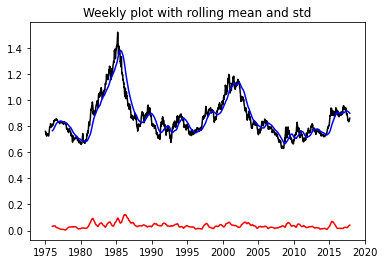

In [62]:
test_stationarity(ts_week)

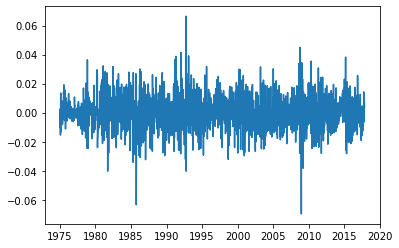

In [67]:
#taking diff
ts_week_log=np.log(ts_week)
ts_week_log_diff = ts_week_log - ts_week_log.shift()  # taking diff
plt.plot(ts_week_log_diff)

In [68]:
ts_week_log_diff.dropna(inplace=True)

Results of DF test results
Test Stats                  -36.590004
p-value                       0.000000
# lags used                   0.000000
# of observation used      2235.000000
critical values : (1%)       -3.433279
critical values : (5%)       -2.862834
critical values : (10%)      -2.567459
dtype: float64


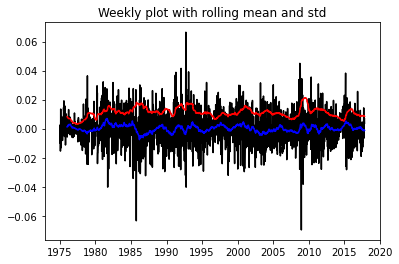

In [69]:
test_stationarity(ts_week_log_diff)

In [70]:
lag_acf=acf(ts_week_log_diff, nlags=10)
lag_pacf=pacf(ts_week_log_diff,nlags=10,method='ols')

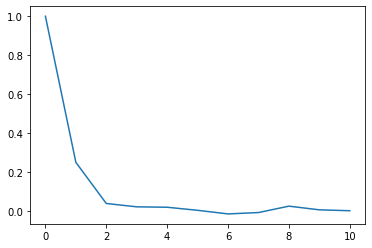

In [71]:
plt.plot(lag_acf)  # 2-1 =1 this is q=1


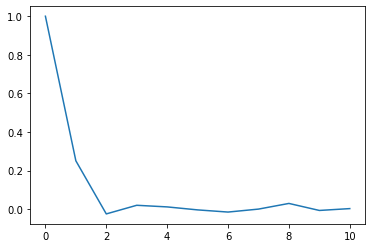

In [72]:
plt.plot(lag_pacf)  # cutting at 2. so the value of p=2

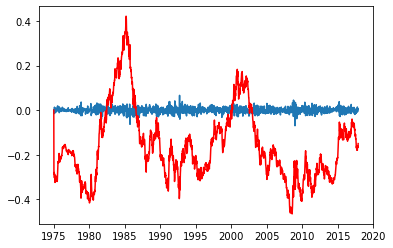

In [134]:
# so we have q=1, p=2, d=1
q=1
p=2
d=1
model=ARIMA(ts_week_log,order=(p,d,q))
results_arima=model.fit()
plt.plot(ts_week_log_diff)
plt.plot(results_arima.fittedvalues, color='red')
#plt.title('RSS: %.4f' %sum(results_arima.fittedvalues - ts_week_log_diff)**2)

In [124]:
print(results_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                 2237
Model:                 ARIMA(2, 1, 1)   Log Likelihood                6869.699
Date:                Sun, 06 Mar 2022   AIC                         -13731.397
Time:                        17:57:59   BIC                         -13708.547
Sample:                    01-05-1975   HQIC                        -13723.055
                         - 11-12-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5344      0.164     -3.257      0.001      -0.856      -0.213
ar.L2          0.1729      0.053      3.258      0.001       0.069       0.277
ma.L1          0.7921      0.163      4.874      0.0

In [125]:
residuals = pd.DataFrame(results_arima.resid)

<AxesSubplot:ylabel='Density'>

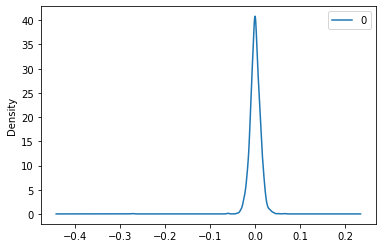

In [126]:
residuals.plot(kind = 'kde')

In [127]:
print(residuals.describe())

                 0
count  2237.000000
mean     -0.000079
std       0.012608
min      -0.273253
25%      -0.006731
50%      -0.000237
75%       0.006875
max       0.064869


In [128]:
pred =pd.Series(results_arima.fittedvalues,copy=True)
pred

Date
1975-01-05    0.000000
1975-01-12   -0.273253
1975-01-19   -0.285537
1975-01-26   -0.279503
1975-02-02   -0.300117
                ...   
2017-10-15   -0.159667
2017-10-22   -0.168354
2017-10-29   -0.164361
2017-11-05   -0.157170
2017-11-12   -0.149864
Freq: W-SUN, Length: 2237, dtype: float64

2017-11-19   -0.146953
2017-11-26   -0.146757
2017-12-03   -0.146715
2017-12-10   -0.146704
2017-12-17   -0.146702
                ...   
2060-08-29   -0.146701
2060-09-05   -0.146701
2060-09-12   -0.146701
2060-09-19   -0.146701
2060-09-26   -0.146701
Freq: W-SUN, Name: predicted_mean, Length: 2237, dtype: float64

In [ ]:
pred_diff_cumsum = pred_cumsum()
pred_log = pd.Series(ts_week_log